# TP2: Machine learning

In [1]:
import pandas as pd
%matplotlib inline
from datetime import datetime
import scipy.spatial
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_training = pd.read_csv('data/properati-merge2017-2016-2015-SOLOSIX.csv')

In [3]:
def recuperar_cant_amb(x):
    "Recupera el dato amb en x (puede ser la descripcion o el titulo)"
    try:
        x = x.lower()
        if x.rfind("ambientes") != -1 or x.rfind("amb") != -1:
            pos = x.rfind("amb")
            try:
                return (float(x[pos -2])) # intento convertir lo que hay antes de la palabra
                                              #si funciona es el numero de rooms
            except ValueError:
                if "dos amb" in x:
                    return 2.0
                elif "tres amb" in x:
                    return 3.0
                elif "cuatro amb" in x:
                    return 4.0
                elif "cinco amb" in x:
                    return 5.0
                elif "seis amb" in x:
                    return 6.0
                return 0
    except AttributeError:
        return None

In [4]:
def contar_ambientes(x):
    "Define la cantidad de ambientes en la descripcion"
    contador = 0
    try:
        x = x.lower()
        if x.rfind("dormitorios") != -1:
            pos = x.rfind("dormitorios")
            try:
                contador += (float(x[pos -2])) # intento convertir lo que hay antes de la palabra
                                              #si funciona es el numero de rooms
            except ValueError:
                if "dos dormitorios" in x:
                    contador += 2.0
                elif "tres dormitorios" in x:
                    contador += 3.0
                elif "cuatro dormitorios" in x:
                    contador += 4.0
                elif "cinco dormitorios" in x:
                    contador += 5.0
                elif "seis dormitorios" in x:
                    contador += 6.0
        if ("living" or "comedor") in x:
            contador += 1.0
    except AttributeError:
        return None
    return contador

In [5]:
def place_name_from_parent(x): ## Segun vi el 3 item del place es generalmente el lugar
    list = x.split('|')
    if(len(list) < 5):
        return list[2]
    else:
        return list[3]

In [6]:
data_training = data_training[data_training['state_name'].str.contains('G.B.A') | data_training['state_name'].str.contains('Capital Federal')]
##El tp dice solo gba y caba

data_training.dropna(axis=0,subset=['price'],inplace=True) ## drop de los datos sin precio
data_training = data_training.loc[data_training['price'] > 0,:]

#Recuperamos el dato rooms en el titulo y la descripcion
data_training.loc[data_training.rooms.isnull(),'rooms'] = data_training.description.apply(recuperar_cant_amb)
data_training.loc[data_training.rooms.isnull(),'rooms'] = data_training.title.apply(recuperar_cant_amb)
#Recuperamos el dato rooms en la descripcion contando ambientes (living y dormitorios)
data_training.loc[data_training.rooms.isnull(),'rooms'] = data_training.description.apply(contar_ambientes)
#Recuperamos el dato rooms en el titulo y la descripcion
data_training.loc[data_training.rooms == 0,'rooms'] = data_training.description.apply(contar_ambientes)

data_training.loc[:,'place_name'] = data_training.place_with_parent_names.apply(place_name_from_parent)
## esto quita muchos problemas de place name como nombres de country o palermo soho

In [7]:
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235829 entries, 0 to 264020
Data columns (total 23 columns):
id                            235829 non-null object
created_on                    235829 non-null object
property_type                 235829 non-null object
place_name                    235829 non-null object
place_with_parent_names       235829 non-null object
state_name                    235829 non-null object
geonames_id                   187297 non-null float64
lat-lon                       168010 non-null object
lat                           168010 non-null float64
lon                           168010 non-null float64
price                         235829 non-null float64
currency                      235829 non-null object
price_aprox_local_currency    235829 non-null float64
price_aprox_usd               235829 non-null float64
surface_total_in_m2           171042 non-null float64
surface_covered_in_m2         212097 non-null float64
price_usd_per_m2              160

In [8]:
data_training = data_training.dropna(axis = 0, subset = ['lat','lon','price_aprox_usd','surface_total_in_m2',\
                                                        'price_usd_per_m2'],how ='any')
data_training['year'] = 0
data_training['month'] = 0
data_training.loc[:,'created_on'] = data_training.created_on.apply(pd.to_datetime)
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112599 entries, 0 to 264017
Data columns (total 25 columns):
id                            112599 non-null object
created_on                    112599 non-null datetime64[ns]
property_type                 112599 non-null object
place_name                    112599 non-null object
place_with_parent_names       112599 non-null object
state_name                    112599 non-null object
geonames_id                   92005 non-null float64
lat-lon                       112599 non-null object
lat                           112599 non-null float64
lon                           112599 non-null float64
price                         112599 non-null float64
currency                      112599 non-null object
price_aprox_local_currency    112599 non-null float64
price_aprox_usd               112599 non-null float64
surface_total_in_m2           112599 non-null float64
surface_covered_in_m2         107388 non-null float64
price_usd_per_m2          

In [9]:
data_training = data_training[['created_on', 'property_type', 'place_name','place_with_parent_names', 'state_name','lat', 'lon','price_aprox_usd', 'surface_total_in_m2','price_usd_per_m2','rooms']]
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112599 entries, 0 to 264017
Data columns (total 11 columns):
created_on                 112599 non-null datetime64[ns]
property_type              112599 non-null object
place_name                 112599 non-null object
place_with_parent_names    112599 non-null object
state_name                 112599 non-null object
lat                        112599 non-null float64
lon                        112599 non-null float64
price_aprox_usd            112599 non-null float64
surface_total_in_m2        112599 non-null float64
price_usd_per_m2           112599 non-null float64
rooms                      112598 non-null float64
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 10.3+ MB


In [10]:
#Hay un registro con rooms nan
data_training.drop(132299,inplace=True)

In [11]:
data_training.loc[:,'year'] = data_training.created_on.apply(lambda x: x.year)
data_training.loc[:,'month'] = data_training.created_on.apply(lambda x: x.month)

In [12]:
data_training.drop('created_on',1,inplace=True)
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112598 entries, 0 to 264017
Data columns (total 12 columns):
property_type              112598 non-null object
place_name                 112598 non-null object
place_with_parent_names    112598 non-null object
state_name                 112598 non-null object
lat                        112598 non-null float64
lon                        112598 non-null float64
price_aprox_usd            112598 non-null float64
surface_total_in_m2        112598 non-null float64
price_usd_per_m2           112598 non-null float64
rooms                      112598 non-null float64
year                       112598 non-null int64
month                      112598 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 11.2+ MB


In [13]:
from sklearn.preprocessing import LabelEncoder

#Vamos a codificar cada columna que sea de strings
lb_make1 = LabelEncoder()
data_training["property_type_code"] = lb_make1.fit_transform(data_training["property_type"])

lb_make2 = LabelEncoder()
data_training["place_name_code"] = lb_make2.fit_transform(data_training["place_name"])

lb_make3 = LabelEncoder()
data_training["place_with_parent_names_code"] = lb_make3.fit_transform(data_training["place_with_parent_names"])

lb_make4 = LabelEncoder()
data_training["state_name_code"] = lb_make4.fit_transform(data_training["state_name"])

In [14]:
data_training2 = data_training[['lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'price_usd_per_m2', 'rooms', 'year', 'month', 'property_type_code',
       'place_name_code', 'place_with_parent_names_code', 'state_name_code']]

LR: 0.939759 (0.017403)
LDA: 0.955656 (0.011939)
KNN: 0.892920 (0.015760)
CART: 1.000000 (0.000000)
NB: 0.974822 (0.015767)


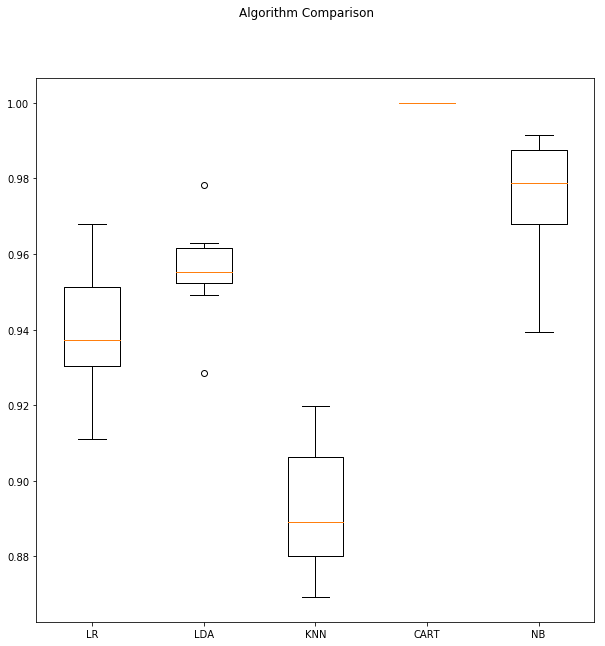

In [15]:
# Compare Algorithms
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
#url = '/home/lucio/Documentos/OrgaDeDatos/ProperatiDatosTP/data/asdasd.csv'
#names = ['created_on', 'lat','lon', 'price_aprox_usd', 'price_usd_per_m2',\
#                'property_type','rooms','surface_total_in_m2']

dataframe = data_training2
array = dataframe.values
X = array[:,0:11]
Y = array[:,11]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) # En casi 3hs nadaaa si alguno lo prueba y le anda en menos copado jaja
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.939652 (0.016707)
LDA: 0.954893 (0.005225)
KNN: 0.886020 (0.013099)
CART: 1.000000 (0.000000)
NB: 0.963836 (0.019471)


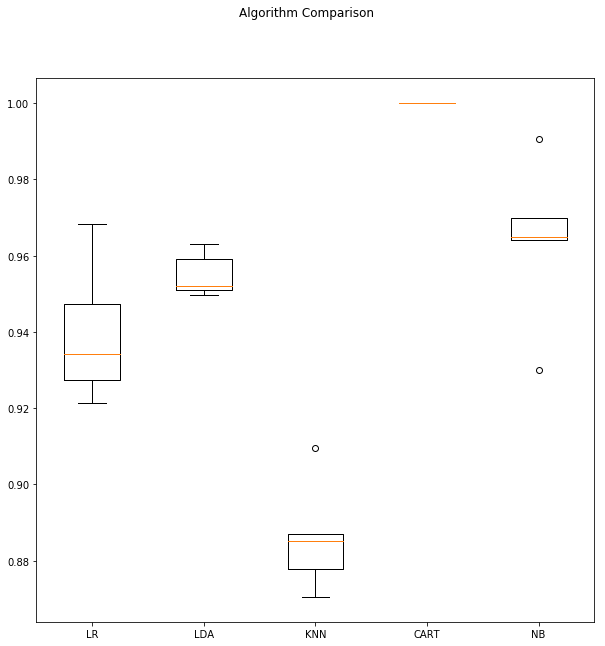

In [16]:
dataframe = data_training2
array = dataframe.values
X = array[:,0:11]
Y = array[:,11]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) # En casi 3hs nadaaa si alguno lo prueba y le anda en menos copado jaja
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [17]:
#Sin considerar latitudes
data_training3 = data_training[['price_aprox_usd', 'surface_total_in_m2',
       'price_usd_per_m2', 'rooms', 'year', 'month', 'property_type_code',
       'place_name_code', 'place_with_parent_names_code', 'state_name_code']]

LR: 0.929608 (0.018222)
LDA: 0.955497 (0.012202)
KNN: 0.892947 (0.015752)
CART: 1.000000 (0.000000)
NB: 0.975302 (0.015308)


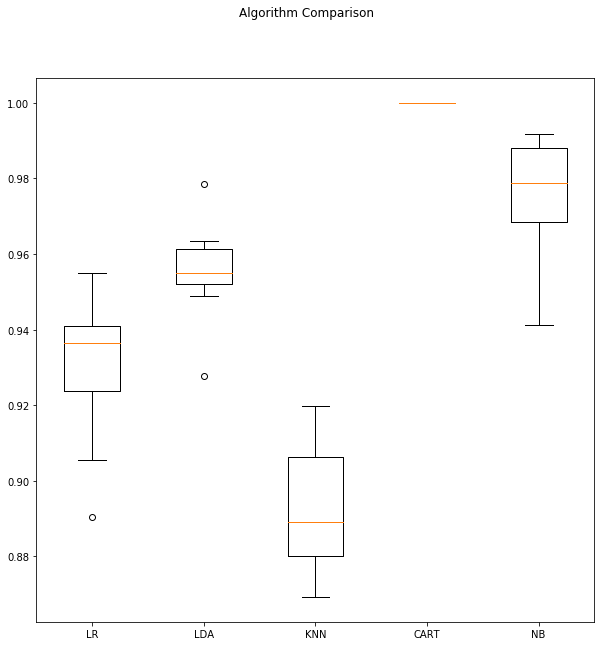

In [18]:
dataframe = data_training3
array = dataframe.values
X = array[:,0:9]
Y = array[:,9]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) # En casi 3hs nadaaa si alguno lo prueba y le anda en menos copado jaja
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()